#### Вступ
В даному проекті потрібно за історичними даними передбачити, чи підпише клієнт договір про депозит з банком на основі його попередньої активності та інших параметрів
В цій задачі дані було проведено дата аналіз, визначені параметри даних, які впливають на кінцевий результат, натреновані різні види моделей і проведено порівняння ефективності цих моделей за параметром auc

In [1]:
%load_ext autoreload
%autoreload 2

In [148]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
from scripts.process_bank_churn import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import STATUS_OK, fmin, tpe, hp, Trials
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [3]:
pd.set_option('display.max.columns',130)
pd.set_option('display.max.rows',130)

***Preprocessing***

In [4]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')


In [5]:
#ця функція додає нові колонки для перетворення yes/no на 1/0
starting_preprocessing(df, ('default', 'housing', 'loan', 'y'))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,default_F,housing_F,loan_F,y_F
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,0.0,0.0,0.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,NaN,0.0,0.0,0.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,0.0,0.0,0.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,0.0,1.0,0.0,1.0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0.0,0.0,0.0,0.0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0.0,1.0,0.0,0.0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,0.0,0.0,0.0,1.0


In [6]:
#перетворюємо місяці з назвами на числа (створюємо для цбього нову колонку)
preprocess_month(df, 'month')

{'ordinalEncoder': OrdinalEncoder(categories=[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul',
                             'aug', 'sep', 'oct', 'nov', 'dec']]),
 'df':        age          job  marital            education  default housing loan  \
 0       56    housemaid  married             basic.4y       no      no   no   
 1       57     services  married          high.school  unknown      no   no   
 2       37     services  married          high.school       no     yes   no   
 3       40       admin.  married             basic.6y       no      no   no   
 4       56     services  married          high.school       no      no  yes   
 ...    ...          ...      ...                  ...      ...     ...  ...   
 41183   73      retired  married  professional.course       no     yes   no   
 41184   46  blue-collar  married  professional.course       no      no   no   
 41185   56      retired  married    university.degree       no     yes   no   
 41186   44   technician  marri

In [7]:
#перетворюємо дні тижня в числові значення (створюємо для цбього нову колонку)
preprocess_day(df, 'day_of_week')

{'ordinalEncoder': OrdinalEncoder(categories=[['mon', 'tue', 'wed', 'thu', 'fri']]),
 'df':        age          job  marital            education  default housing loan  \
 0       56    housemaid  married             basic.4y       no      no   no   
 1       57     services  married          high.school  unknown      no   no   
 2       37     services  married          high.school       no     yes   no   
 3       40       admin.  married             basic.6y       no      no   no   
 4       56     services  married          high.school       no      no  yes   
 ...    ...          ...      ...                  ...      ...     ...  ...   
 41183   73      retired  married  professional.course       no     yes   no   
 41184   46  blue-collar  married  professional.course       no      no   no   
 41185   56      retired  married    university.degree       no     yes   no   
 41186   44   technician  married  professional.course       no      no   no   
 41187   74      retired  mar

In [8]:
#перевіряємо збалансованість
df.y.value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

Дані дуже не збалансовані по таргет-змінній

In [9]:
#створюємо нову категоріальну колонку для групувань по віку
preprocess_age(df, 'age')

In [10]:
df.age_L.value_counts()

age_L
30-40    16938
40-50    10526
50-60     6862
20-30     5594
g_60      1193
l_20        75
Name: count, dtype: int64

***EDA***

In [11]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,default_F,housing_F,loan_F,y_F,month_L,day_of_week_L
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,32591.000000,40198.000000,40198.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.000092,0.536743,0.155431,0.112654,5.607896,1.979581
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.009594,0.498654,0.362319,0.316173,2.040998,1.411514
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000,1.000000,0.000000,0.000000,5.000000,2.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000,1.000000,0.000000,0.000000,7.000000,3.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000,1.000000,1.000000,1.000000,11.000000,4.000000


In [12]:
corr = df.select_dtypes('number').corr()

In [13]:
corr.y_F.to_frame().sort_values('y_F')

,y_F
nr.employed,-0.354678
pdays,-0.324914
euribor3m,-0.307771
emp.var.rate,-0.298334
cons.price.idx,-0.136211
campaign,-0.066357
loan_F,-0.004682
default_F,-0.003689
day_of_week_L,0.010051
housing_F,0.011662


Бачимо, що найвпливовішими є колонки duration, previous (позитивна кореляція), cons.price.idx, emp.var.rate, euribor3m, pdays, nr.employed (негативна кореляція)
    
	- emp.var.rate (employment variation rate): Зміна рівня зайнятості, зазвичай вимірюється як відсоток зміни в рівні зайнятості в певний період часу. Цей показник може використовуватися для оцінки змін на ринку праці.
	- euribor3m (Euribor 3-month rate): Ставка Euribor (Euro Interbank Offered Rate) на 3 місяці. Euribor є середньою процентною ставкою, за якою європейські банки пропонують один одному короткострокові позики на євро. Цей показник використовується як базова ставка для багатьох фінансових продуктів, таких як іпотеки та кредити.
	- pdays (number of days since the client was last contacted from a previous campaign): Кількість днів, що минули з моменту останнього контакту клієнта під час попередньої кампанії. Це може бути корисним для аналізу ефективності маркетингових кампаній та визначення оптимальних інтервалів між контактами з клієнтами.
	- nr.employed (number of employees): Кількість зайнятих працівників. Цей показник може відображати загальний рівень зайнятості в компанії чи в певному секторі економіки. Він може використовуватися для аналізу ринку праці та економічних тенденцій.
	- cons.price.idx може стосуватися індексу споживчих цін (Consumer Price Index, CPI)


In [14]:
nan_count = df.isna().sum()

In [15]:
print(nan_count)

age                  0
job                  0
marital              0
education            0
default              0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
default_F         8597
housing_F          990
loan_F             990
y_F                  0
month_L              0
day_of_week_L        0
age_L                0
dtype: int64


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  int64   
 1   job             41188 non-null  object  
 2   marital         41188 non-null  object  
 3   education       41188 non-null  object  
 4   default         41188 non-null  object  
 5   housing         41188 non-null  object  
 6   loan            41188 non-null  object  
 7   contact         41188 non-null  object  
 8   month           41188 non-null  object  
 9   day_of_week     41188 non-null  object  
 10  duration        41188 non-null  int64   
 11  campaign        41188 non-null  int64   
 12  pdays           41188 non-null  int64   
 13  previous        41188 non-null  int64   
 14  poutcome        41188 non-null  object  
 15  emp.var.rate    41188 non-null  float64 
 16  cons.price.idx  41188 non-null  float64 
 17  cons.conf.id

In [17]:
df_y = df[df['y_F']==1]
df_n = df[df['y_F']==0]

In [18]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,default_F,housing_F,loan_F,y_F,month_L,day_of_week_L
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,32591.000000,40198.000000,40198.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.000092,0.536743,0.155431,0.112654,5.607896,1.979581
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.009594,0.498654,0.362319,0.316173,2.040998,1.411514
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000,1.000000,0.000000,0.000000,5.000000,2.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000,1.000000,0.000000,0.000000,7.000000,3.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000,1.000000,1.000000,1.000000,11.000000,4.000000


duration, campaign, previous, age - тут схоже є викиди

Стовпці видаляти не буду, так як cеред числових значень немає незаповнених даних, а для категоріальних unknown не заважає

In [19]:
for column in ('duration', 'campaign', 'previous', 'age'):
    range = calculate_outliers_range(df, column)
    cnt = df[df[column] > range['max_value']].shape[0]
    print("Outliers count for {} is {},  max value is {}, pencentage is {}".format(column, cnt,range['max_value'], cnt/df.shape[0]))

Outliers count for duration is 2963,  max value is 644.5, pencentage is 0.07193842866854423
Outliers count for campaign is 2406,  max value is 6.0, pencentage is 0.058415072351170244
Outliers count for previous is 5625,  max value is 0.0, pencentage is 0.1365689035641449
Outliers count for age is 469,  max value is 69.5, pencentage is 0.011386811692726036


Кількість аутлаерів виглядає досить великою, можливао варто проаналізувати їх набори окремо

In [20]:
df.previous.value_counts()

previous
0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: count, dtype: int64

Тепер потрібно візуально оцінити вплив категоріальних змінних (job, marital, education, contact, poutcome, age_L) на цільову

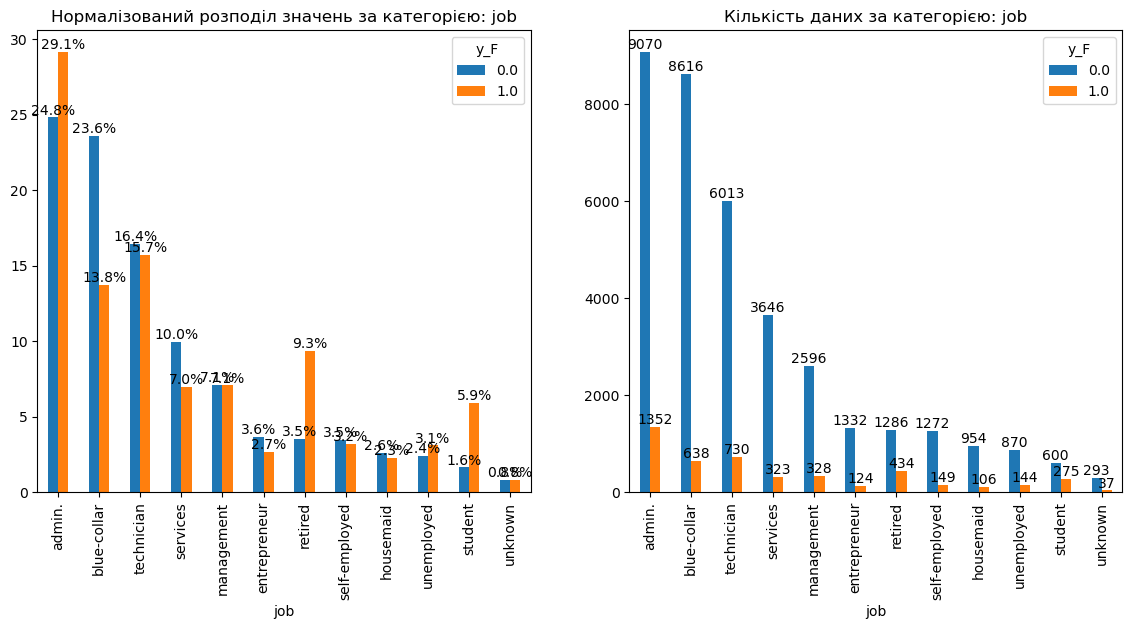

In [21]:
bi_cat_countplot(df, 'job', hue_column='y_F')

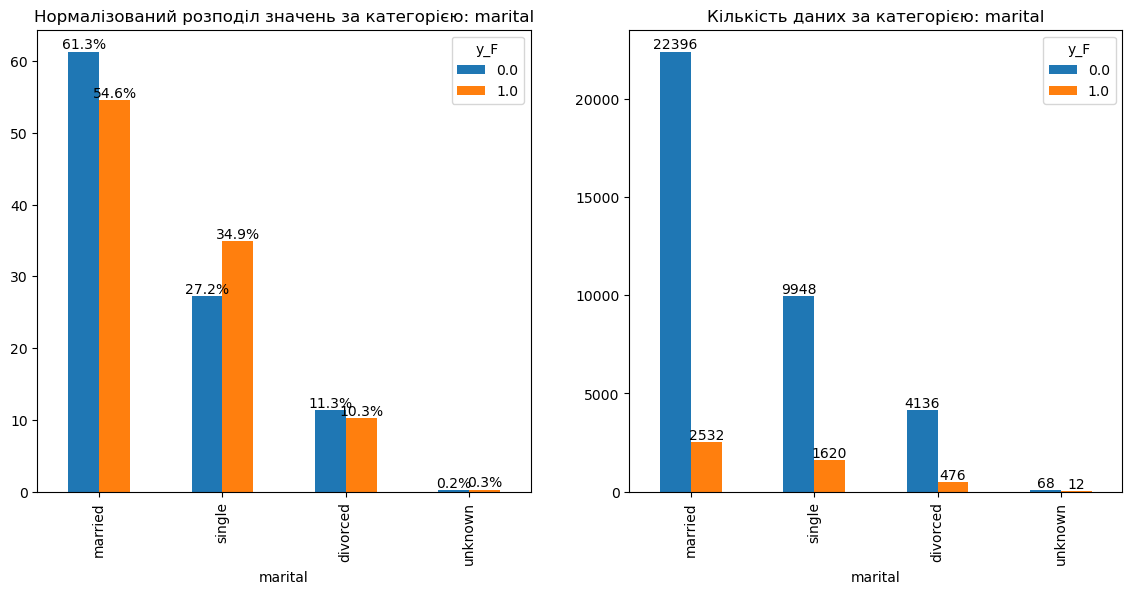

In [22]:
bi_cat_countplot(df, 'marital', hue_column='y_F')

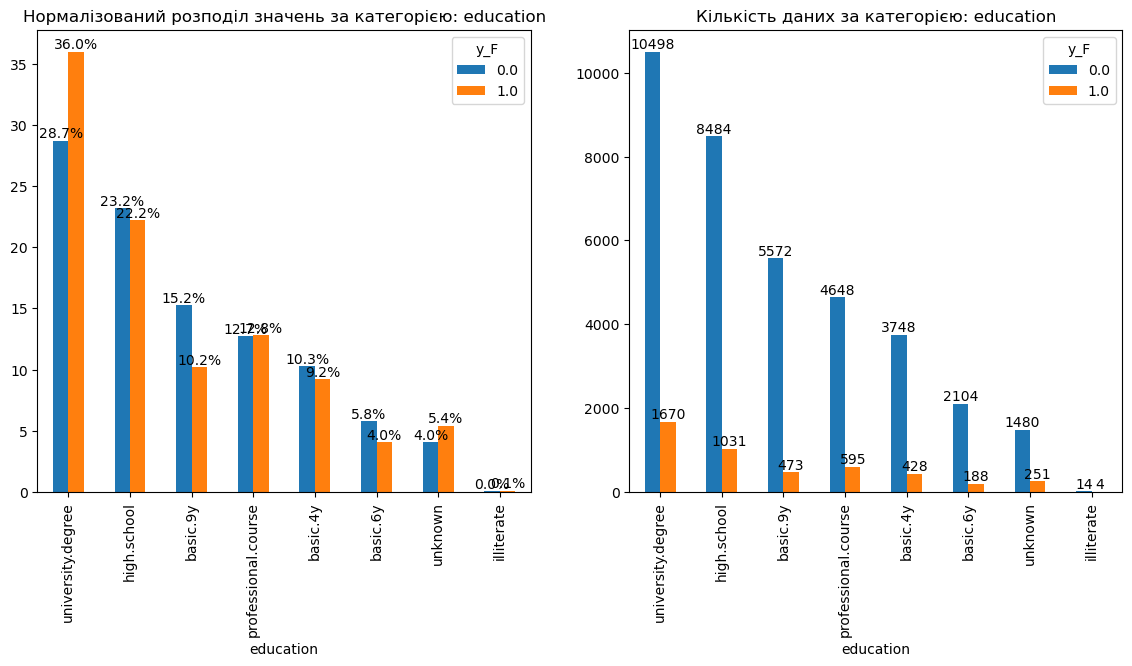

In [23]:
bi_cat_countplot(df, 'education', hue_column='y_F')

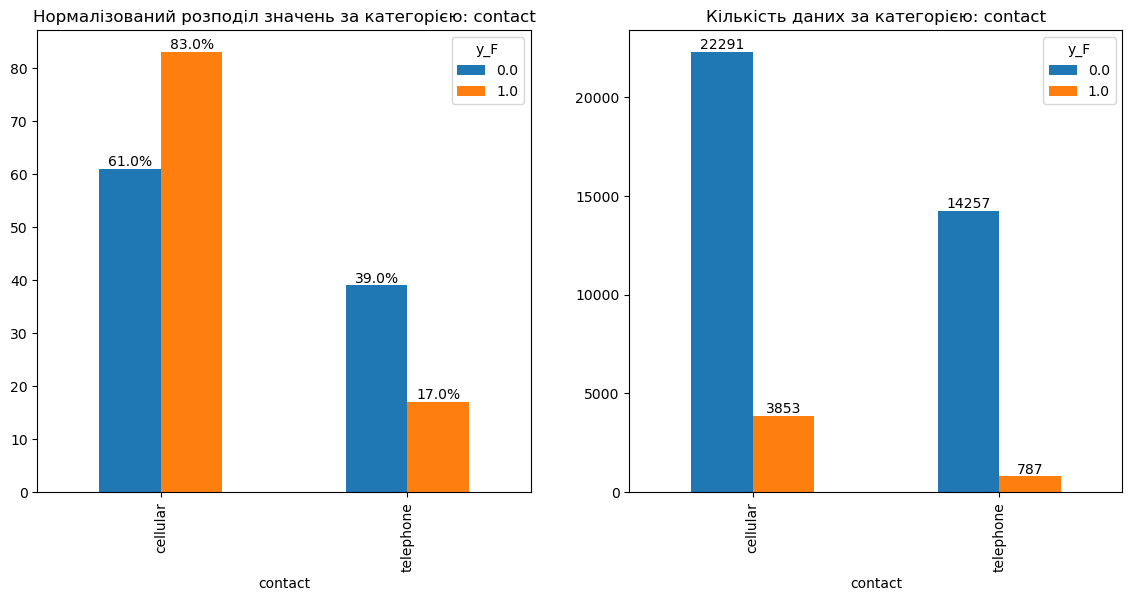

In [24]:
bi_cat_countplot(df, 'contact', hue_column='y_F')

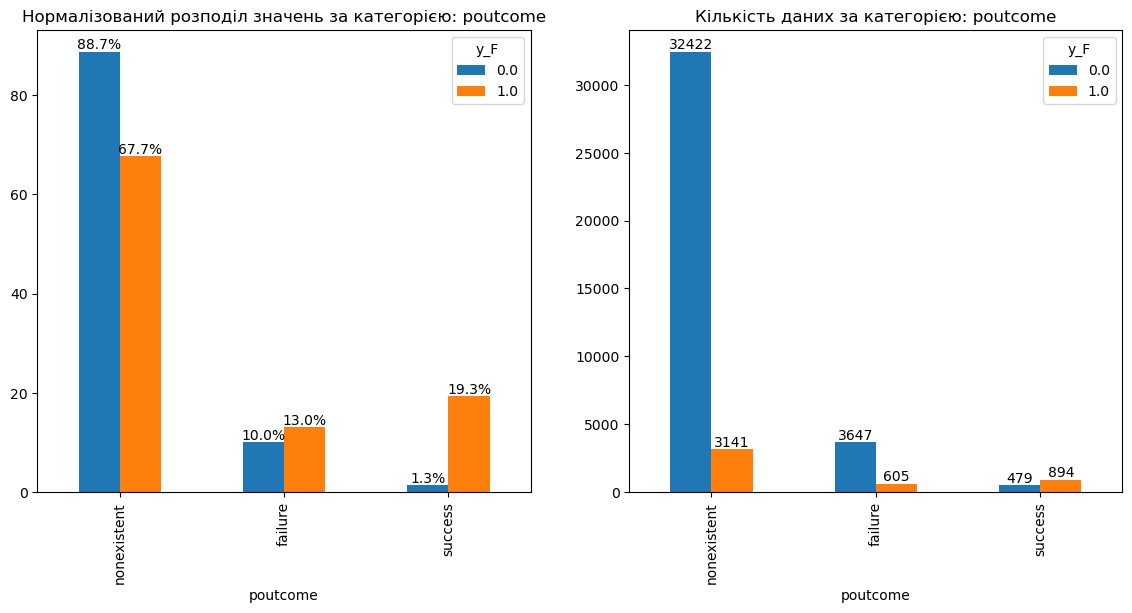

In [25]:
bi_cat_countplot(df, 'poutcome', hue_column='y_F')

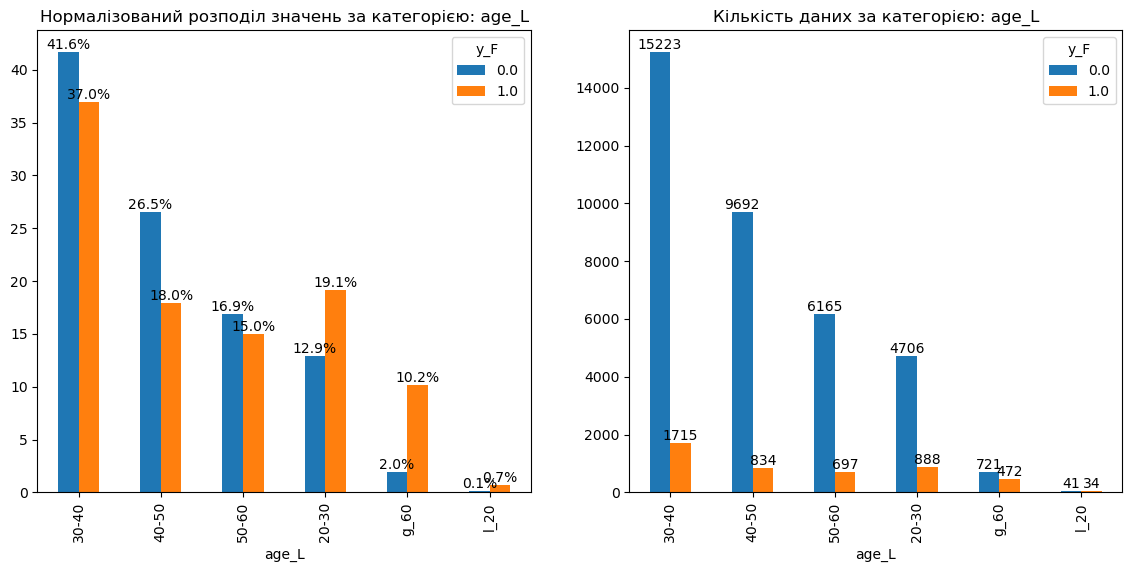

In [26]:
bi_cat_countplot(df, 'age_L', hue_column='y_F')

Отже, по категориальных ознаках можемо зробити висновок, що люди з вищою освітою, студенти та пенсіонери, а також ті люди, які раніше співпрацювали з компанією, з більшою імовірністю погоджувались на депозит

***Робимо обробку даних для передачі їх в моделі***

In [27]:
number_cols_to_scale = df.select_dtypes("number").drop("y_F", axis=1).columns.to_list()
categorical_cols = df.select_dtypes("object").drop("y", axis=1).drop("default", axis=1).drop("housing", axis=1).drop("loan", axis=1).drop("month", axis=1).drop("day_of_week", axis=1).columns.to_list()

In [28]:
preprocessed_data = preprocess_data(df, number_cols_to_scale=number_cols_to_scale, categorical_cols=categorical_cols, scaleNumeric= True, targetColumn='y_F')

***Розбиваємо набір на тренувальний та валідаційний***

In [29]:
inputs_train, inputs_val, targets_train, targets_val, scalerObj, encoderObj, number_cols, categorical_cols, number_cols_to_scale = preprocessed_data.values()

***Логістична регресія***

In [36]:
logisticRegressionModel = LogisticRegression(solver='liblinear')
logisticRegressionModel.fit(inputs_train, targets_train['y_F'])

LogisticRegression(solver='liblinear')

In [37]:
getMetricsData(logisticRegressionModel, inputs_train, targets_train, inputs_val, targets_val, 'y_F')

Train auc=0.9261567359415581
Train roc_auc_score=0.678577740398946
Train f1=0.48608988077040655
Val auc=0.929447143733195
Val roc_auc_score=0.680216047926789
Val f1=0.4964739069111425


LogisticRegression(solver='liblinear')

Логістична регресія показує хороші результати

***KNeighbors***

In [41]:
knnModel = KNeighborsClassifier()
knnModel.fit(inputs_train, targets_train['y_F'])
getMetricsData(knnModel, inputs_train, targets_train, inputs_val, targets_val, 'y_F')

Train auc=0.941915818595835
Train roc_auc_score=0.6688975992108628
Train f1=0.4790516401429035
Val auc=0.7386365512524176
Val roc_auc_score=0.5940619250908061
Val f1=0.300148588410104


KNeighborsClassifier()

kNN показує не дуже хороші результати на валідаційних даних

***DecisionTree***

In [45]:
dtModel = DecisionTreeClassifier(random_state=42)
dtModel.fit(inputs_train, targets_train['y_F'])
getMetricsData(dtModel, inputs_train, targets_train, inputs_val, targets_val, 'y_F')

Train auc=1.0
Train roc_auc_score=1.0
Train f1=1.0
Val auc=0.7376424005849332
Val roc_auc_score=0.7376424005849332
Val f1=0.52565445026178


DecisionTreeClassifier(random_state=42)

In [76]:
df.drop("y", axis=1, inplace=True)

In [77]:
it = getInputsAndTargets(df, 'y_F')
inputs = it['inputs']
targets = it['targets']
inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=0.1, random_state=42, stratify=df['y_F'])

In [78]:
for col in inputs_train.select_dtypes(include=['object']).columns:
    inputs_train[col] = inputs_train[col].astype('category')
    inputs_val[col] = inputs_val[col].astype('category')

***XGB***

In [79]:
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators = 10,
    enable_categorical=True,
    missing = np.nan
)
xgb_clf.fit(inputs_train, targets_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [80]:
getMetricsData(xgb_clf, inputs_train, targets_train, inputs_val, targets_val, 'y_F')

Train auc=0.9441646965319922
Train roc_auc_score=0.7095999322020907
Train f1=0.5397009725649586
Val auc=0.9463633308174914
Val roc_auc_score=0.707275696966838
Val f1=0.5444743935309972


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [81]:
xgb_clf.get_booster().get_score(importance_type='weight')

{'job': 2.0,
 'contact': 2.0,
 'month': 10.0,
 'duration': 24.0,
 'pdays': 4.0,
 'poutcome': 4.0,
 'emp.var.rate': 7.0,
 'cons.price.idx': 2.0,
 'cons.conf.idx': 2.0,
 'euribor3m': 8.0,
 'nr.employed': 5.0}

***Використаємо RandomizedSearchCV***

In [122]:
params = {'eta': np.arange(0, 1, 0.1),
    'gamma': np.arange(1, 10),
    'max_depth': np.arange(5, 50),
    }
randomSearchXGB = RandomizedSearchCV(
    XGBClassifier(enable_categorical=True, missing = np.nan),
    params,
    n_iter = 50,
    cv=5,
    scoring="roc_auc",
    verbose=3
)

In [123]:
randomSearchXGB.fit(inputs_train, targets_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END eta=0.6000000000000001, gamma=8, max_depth=28;, score=0.943 total time=   0.1s
[CV 2/5] END eta=0.6000000000000001, gamma=8, max_depth=28;, score=0.948 total time=   0.1s
[CV 3/5] END eta=0.6000000000000001, gamma=8, max_depth=28;, score=0.949 total time=   0.1s
[CV 4/5] END eta=0.6000000000000001, gamma=8, max_depth=28;, score=0.950 total time=   0.1s
[CV 5/5] END eta=0.6000000000000001, gamma=8, max_depth=28;, score=0.942 total time=   0.1s
[CV 1/5] END eta=0.7000000000000001, gamma=4, max_depth=15;, score=0.937 total time=   0.1s
[CV 2/5] END eta=0.7000000000000001, gamma=4, max_depth=15;, score=0.945 total time=   0.1s
[CV 3/5] END eta=0.7000000000000001, gamma=4, max_depth=15;, score=0.945 total time=   0.1s
[CV 4/5] END eta=0.7000000000000001, gamma=4, max_depth=15;, score=0.945 total time=   0.1s
[CV 5/5] END eta=0.7000000000000001, gamma=4, max_depth=15;, score=0.940 total time=   0.1s
[CV 1/5] END ....e

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=50,
                   param_distributions={'eta': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'gamma': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
                   scoring='roc_auc', verbose=3)

In [124]:
randomSearchXGB.best_estimator_.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': True,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 8,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 15,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.1}

In [125]:
importance_df = pd.DataFrame({
    'feature': randomSearchXGB.best_estimator_.feature_names_in_.tolist(),
    'importance': randomSearchXGB.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

In [126]:
importance_df.head()

,feature,importance
19,nr.employed,0.624518
10,duration,0.097949
8,month,0.038050
15,emp.var.rate,0.035422
12,pdays,0.025915


In [127]:
getMetricsData(randomSearchXGB.best_estimator_, inputs_train, targets_train, inputs_val, targets_val, 'y_F')

Train auc=0.9591414729379704
Train roc_auc_score=0.7776879598169986
Train f1=0.640512619327841
Val auc=0.9532268621161376
Val roc_auc_score=0.7659453276097928
Val f1=0.6280193236714975


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=8, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Результат круто покращився 

***LGBM***

In [132]:
lgbmModel = LGBMClassifier()
lgbmModel.fit(inputs_train, targets_train['y_F'])

[LightGBM] [Info] Number of positive: 4176, number of negative: 32893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 766
[LightGBM] [Info] Number of data points in the train set: 37069, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112655 -> initscore=-2.063906
[LightGBM] [Info] Start training from score -2.063906


LGBMClassifier()

In [133]:
getMetricsData(lgbmModel, inputs_train, targets_train, inputs_val, targets_val, 'y_F')

[LightGBM] [Info] Number of positive: 4176, number of negative: 32893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 766
[LightGBM] [Info] Number of data points in the train set: 37069, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112655 -> initscore=-2.063906
[LightGBM] [Info] Start training from score -2.063906
Train auc=0.9721975937187721
Train roc_auc_score=0.8157506093716386
Train f1=0.708726567550097
Val auc=0.9506141209491012
Val roc_auc_score=0.7797835393178923
Val f1=0.6395348837209303


LGBMClassifier()

In [152]:
space_ = {
    'n_estimators': hp.quniform('n_estimators', 25, 100, 10),
    'num_leaves': hp.quniform('num_leaves', 15, 50, 5),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.5),
    'reg_lambda': hp.uniform('reg_lambda', 0, 0.8),
    'colsample_bytree': hp.uniform('colsample_bytree', 0, 0.9)
}
def objective(params):
    clf = LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        num_leaves=int(params['num_leaves']),
        learning_rate=float(params['learning_rate']),
        reg_alpha=float(params['reg_alpha']),
        reg_lambda=float(params['reg_lambda']),
        colsample_bytree=float(params['colsample_bytree']),
        missing = np.nan
    )
    clf.fit(inputs_train, targets_train['y_F'], eval_set = [(inputs_val, targets_val['y_F'])])
    pred = clf.predict(inputs_train)
    roc_auc_score_v = roc_auc_score(targets_train['y_F'], pred)
    return {'loss':-roc_auc_score_v, 'status': STATUS_OK}


trials = Trials()
best = fmin(fn=objective,space=space_, max_evals=15, trials=trials, algo=tpe.suggest)    

[LightGBM] [Warning] Unknown parameter: missing       
[LightGBM] [Warning] Unknown parameter: missing       
[LightGBM] [Info] Number of positive: 4176, number of negative: 32893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 766                      
[LightGBM] [Info] Number of data points in the train set: 37069, number of used features: 26
[LightGBM] [Warning] Unknown parameter: missing       
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112655 -> initscore=-2.063906
[LightGBM] [Info] Start training from score -2.063906 
[LightGBM] [Warning] Unknown parameter: missing       
[LightGBM] [Warning] Unknown parameter: missing                                  
[LightGBM] [Warning] Unknown parameter: missing                                  
[LightGBM] [Info] Number of positive:

In [153]:
best

{'colsample_bytree': 0.7791917425679064,
 'learning_rate': 0.46708598190560935,
 'n_estimators': 50.0,
 'num_leaves': 40.0,
 'reg_alpha': 0.3366619742179188,
 'reg_lambda': 0.11611049837531953}

In [155]:
LGBM_best = LGBMClassifier(
        n_estimators=int(best['n_estimators']),
        num_leaves=int(best['num_leaves']),
        learning_rate=float(best['learning_rate']),
        reg_alpha=float(best['reg_alpha']),
        reg_lambda=float(best['reg_lambda']),
        colsample_bytree=float(best['colsample_bytree']),
        missing = np.nan
    )
LGBM_best.fit(inputs_train, targets_train['y_F'])
getMetricsData(LGBM_best, inputs_train, targets_train, inputs_val, targets_val, 'y_F')

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 4176, number of negative: 32893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 766
[LightGBM] [Info] Number of data points in the train set: 37069, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112655 -> initscore=-2.063906
[LightGBM] [Info] Start training from score -2.063906
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 4176, number of negative: 32893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

LGBMClassifier(colsample_bytree=0.7791917425679064,
               learning_rate=0.46708598190560935, missing=nan, n_estimators=50,
               num_leaves=40, reg_alpha=0.3366619742179188,
               reg_lambda=0.11611049837531953)

In [163]:
feature_importances_lgbm = pd.DataFrame({
    'feature': LGBM_best.feature_names_in_,
    'value': LGBM_best.feature_importances_
}).sort_values('value', ascending=False)

In [165]:
feature_importances_lgbm.head()

,feature,value
10,duration,443
18,euribor3m,310
0,age,308
11,campaign,134
24,day_of_week_L,86


Параметри  duration, euribor3m, age, campaign виглядають логічними, day_of_week_L - не дуже, хоча можливо люди в певні дні тижня справді більш лояльні)

### Висновки

Які ще можна зробити кроки 
- SMOTE і SMOTEENC, 
- робота з викидами, 
- видалити в категоріальних колонках значення unknown (замінивши на np.nan)
- пробувати фітити модель не на всіх колонках, а на найвпливовіших
- пробувати різні параметри для логістичної регресії наприклад

In [166]:
lgbm_pred = LGBM_best.predict(inputs_train)
targets_train_pred = pd.DataFrame({
    'y_F': targets_train['y_F'],
    'pred': lgbm_pred
})

[LightGBM] [Warning] Unknown parameter: missing


In [170]:
inputs_train_2_analize = inputs_train.copy()

In [173]:
inputs_train_2_analize['y'] = targets_train['y_F']
inputs_train_2_analize['pred'] = targets_train_pred['pred']

In [171]:
inputs_train_2_analize['incorrect'] = targets_train_pred['y_F']!=targets_train_pred['pred']

In [174]:
inputs_train_2_analize[inputs_train_2_analize['incorrect'] == True]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,default_F,housing_F,loan_F,month_L,day_of_week_L,age_L,incorrect,y,pred
35921,36,admin.,single,university.degree,no,no,no,cellular,may,mon,327,1,999,0,nonexistent,-1.8,92.893,-46.2,1.264,5099.1,0.0,0.0,0.0,4.0,0.0,30-40,True,0.0,1.0
41120,60,admin.,married,unknown,no,no,no,cellular,nov,tue,333,2,999,0,nonexistent,-1.1,94.767,-50.8,1.046,4963.6,0.0,0.0,0.0,10.0,1.0,g_60,True,0.0,1.0
11936,40,admin.,single,university.degree,no,no,no,telephone,jun,mon,498,2,999,0,nonexistent,1.4,94.465,-41.8,4.958,5228.1,0.0,0.0,0.0,5.0,0.0,40-50,True,1.0,0.0
39996,30,technician,single,university.degree,no,yes,no,telephone,jun,wed,263,1,999,2,failure,-1.7,94.055,-39.8,0.767,4991.6,0.0,1.0,0.0,5.0,2.0,30-40,True,1.0,0.0
38713,57,technician,married,professional.course,no,no,no,cellular,nov,tue,564,1,999,0,nonexistent,-3.4,92.649,-30.1,0.715,5017.5,0.0,0.0,0.0,10.0,1.0,50-60,True,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36267,33,admin.,married,university.degree,no,no,no,cellular,jun,mon,335,2,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,0.0,0.0,0.0,5.0,0.0,30-40,True,1.0,0.0
37272,36,management,married,university.degree,no,no,no,telephone,aug,mon,328,1,999,0,nonexistent,-2.9,92.201,-31.4,0.884,5076.2,0.0,0.0,0.0,7.0,0.0,30-40,True,1.0,0.0
28347,46,technician,married,basic.6y,unknown,yes,no,cellular,apr,wed,575,2,999,0,nonexistent,-1.8,93.075,-47.1,1.445,5099.1,NaN,1.0,0.0,3.0,2.0,40-50,True,1.0,0.0
12404,52,blue-collar,married,basic.9y,no,no,no,cellular,jul,mon,1434,5,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,0.0,0.0,0.0,6.0,0.0,50-60,True,0.0,1.0


inputs_train_2_analize - тут дані, на яких модель помилилася,

| Модель | Гіперпараметри| auc (train)| auc (val)| Коментар|
|------|----|---|---|----|
|LogisticRegression|solver='liblinear'|0.926|0.929||
|KNeighborsClassifier|дефолтні|0.942|0.739| |
|DecisionTreeClassifier|random_state=42|1.0|0.738|Дерево перенавчене, можливо потрібен пруннінг|
|XGBClassifier|eta=0.1, gamma=8, max_depth=15|0.959|0.953|Як на мене - найкраща з модель з хорошими результатами|
|LGBMClassifier|colsample_bytree=0.7791917425679064,learning_rate=0.46708598190560935, n_estimators=50,num_leaves=40, reg_alpha=0.3366619742179188, reg_lambda=0.11611049837531953|0.986|0.946|Можливо тут невдало насетапила парметри для пошуку, модель виглядає перенавченою|


Виходячи з набору даних inputs_train_2_analize (дані, на яких можель помилилась), декілька ідей, як ще можна покращити модель:

згрупувати по професії, спробувати умовно визначити безробітних (студенти та пенсіонери, по них найбільше помилок). Створення цієї ознаки також відразу опрацювало б проблему з віком;

duration теж можна було умовно поділити на 3 групи (0-500; 500-1500; >1500). Також більше 1500 можна було б спробувати не враховувати в навчанні моделі взагалі. Вважати це викидами і замінити на моду чи середнє;

nr.employed теж можна було б поділити на 2 групи по пересантилям чи середньому. Також, можна спробувати взагалі не тренувати модель на цих даних.

Також, не можна точно сказати правильним чи ні було рішення місяці та дні додавати в окремі колонки, адже потрібно експерементувати та тестувати різні набори даних на моделях, і дивитися, коли виходять кращі результати.